In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import re
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import warnings
import time
import datetime
warnings.filterwarnings("ignore", category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

In [11]:
df = pd.read_csv("googleplaystore.csv")

df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


### Data preprocessing and cleaning

In [12]:
df.shape

(10841, 13)

In [13]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews            object
Size               object
Installs           object
Type               object
Price              object
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

In [14]:
# drop 10472 cuz it's abnormal
df.drop([10472],inplace = True)

In [15]:
# 13.5% of rating data are missing. Other fileds almost have no NA
# Curren Ver adn Android Ver NA could be ignored
for name in df.columns:
    print(name,":",df[name].isnull().sum(),",",df[name].isnull().sum()/df.shape[0])

App : 0 , 0.0
Category : 0 , 0.0
Rating : 1474 , 0.13597785977859778
Reviews : 0 , 0.0
Size : 0 , 0.0
Installs : 0 , 0.0
Type : 1 , 9.225092250922509e-05
Price : 0 , 0.0
Content Rating : 0 , 0.0
Genres : 0 , 0.0
Last Updated : 0 , 0.0
Current Ver : 8 , 0.0007380073800738007
Android Ver : 2 , 0.00018450184501845018


In [16]:
# repalce NA in Rating column with mean/median
df['Rating'].fillna(df['Rating'].mean(), inplace = True)

#For Current Version column, before filling null values we have to clean all non numerical values & unicode charachters 
replaces = [u'\u00AE', u'\u2013', u'\u00C3', u'\u00E3', u'\u00B3', '[', ']', "'"]
for i in replaces:
    df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace(i, ''))

regex = [r'[-+|/:/;(_)@]', r'\s+', r'[A-Za-z]+']
for j in regex:
    df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : re.sub(j, '0', x))

df['Current Ver'] = df['Current Ver'].astype(str).apply(lambda x : x.replace('.', ',',1).replace('.', '').replace(',', '.',1)).astype(float)
df['Current Ver'] = df['Current Ver'].fillna(df['Current Ver'].median())

# replace "," and "+" in installs column
df['Installs'] = df['Installs'].str.replace(',','')
df['Installs'] = df['Installs'].str.replace('+','')
# df['Installs'] = df['Installs'].astype(int)
df['Installs'] = pd.to_numeric(df['Installs'])

df['Reviews'] = df['Reviews'].astype(str).astype(int)

# replace "M" in size column
clean_size = []
for i in range(0,df.shape[0]):
    if len(df['Size'].iloc[i].split('M')) == 2:
        clean_size.append(int(float(df['Size'].iloc[i].split('M')[0])))
    elif len(df['Size'].iloc[i].split('k')) == 2:
        clean_size.append(int(float(df['Size'].iloc[i].split('k')[0]))*0.001)
    else:
        clean_size.append(df['Size'].iloc[i])
df['Size'] = clean_size

# drop Na in Type, Android Ver
df = df[~df['Type'].isna()]
df = df[~df['Android Ver'].isna()]

# Data Cleaning for Size, for those "Varies with device", replace it with median APP size
df[df['Size'] != 'Varies with device']['Size'] = df[df['Size'] != 'Varies with device']['Size'].astype('float')
mid = np.percentile(df[df['Size'] != 'Varies with device']['Size'].astype('float'), 50)
df.loc[df['Size'] == 'Varies with device','Size'] = mid
df['Size'] = df['Size'].astype('float')

# Remove '$' for Price
df['Price'] = df['Price'].str.replace('$','')
df['Price'] = df['Price'].astype("float")

# Last Updated encoding
import datetime
df['Last Updated'] = df['Last Updated'].apply(lambda x : time.mktime(datetime.datetime.strptime(x, '%B %d, %Y').timetuple()))

C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [17]:
df.to_csv('data_after_clean.csv')

### EDA and Correlation Analysis

#### Univariate Exploration

Text(0.5, 1.0, 'Distribution of Reviews')

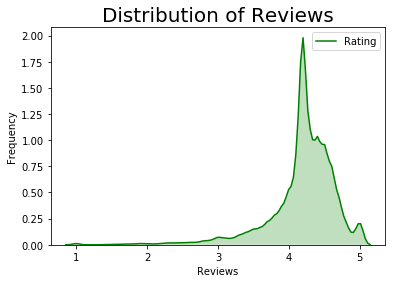

In [74]:
g = sns.kdeplot(df.Rating, color="Green", shade = True)
g.set_xlabel("Reviews")
g.set_ylabel("Frequency")
plt.title('Distribution of Reviews',size = 20)

Text(0.5, 1.0, 'Distribution of Price')

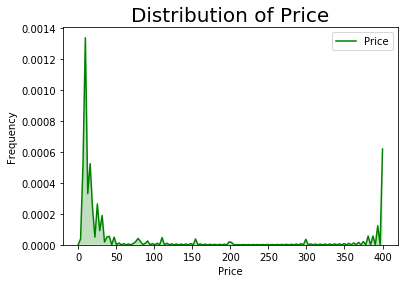

In [19]:
g = sns.kdeplot(df.Price, color="Green", shade = True)
g.set_xlabel("Price")
g.set_ylabel("Frequency")
plt.title('Distribution of Price',size = 20)

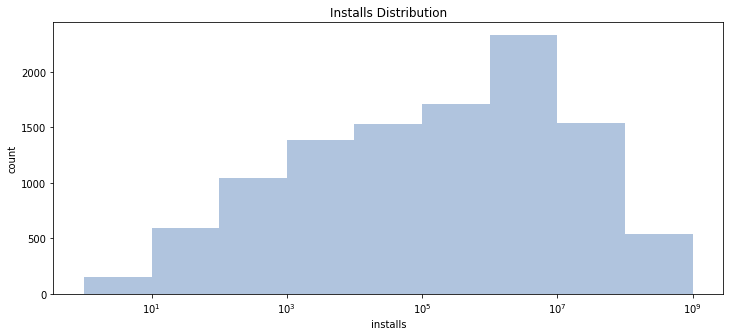

In [20]:
# Installs is highly skewed in distribution, so we convert Installs to a log scale for visualization
log_binsize = 1
bins = 10 ** np.arange(0, np.log10(df['Installs'].max())+log_binsize, log_binsize)

plt.figure(figsize=[12, 5])
plt.hist(data = df, x = 'Installs', bins = bins, color = 'lightsteelblue')
plt.xscale('log')
plt.xlabel('installs')
plt.ylabel('count')
plt.title('Installs Distribution')
plt.show()

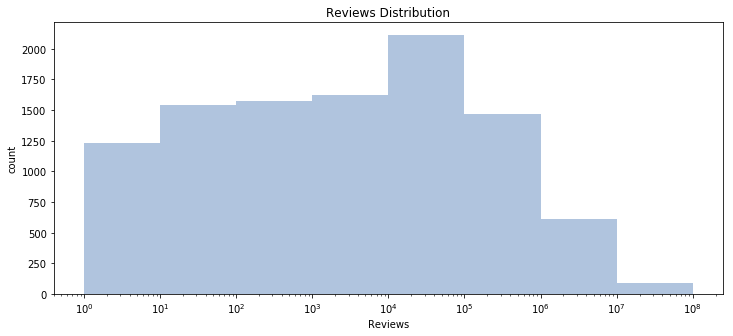

In [21]:
# Reviews is highly skewed in distribution, so we convert Installs to a log scale for visualization
log_binsize = 1
bins = 10 ** np.arange(0, np.log10(df['Reviews'].max())+log_binsize, log_binsize)

plt.figure(figsize=[12, 5])
plt.hist(data = df, x = 'Reviews', bins = bins, color = 'lightsteelblue')
plt.xscale('log')
plt.xlabel('Reviews')
plt.ylabel('count')
plt.title('Reviews Distribution')
plt.show()

#### Bivariate Exploration

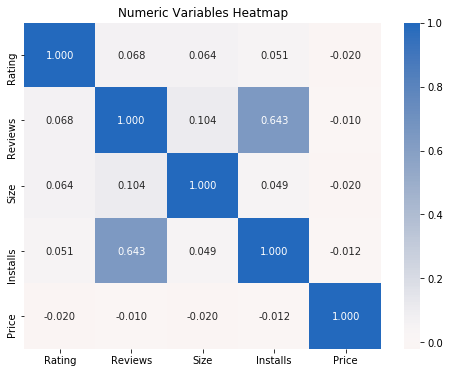

In [22]:
numeric_vars = ['Rating','Reviews','Size','Installs','Price']

plt.figure(figsize = [8, 6])
sns.heatmap(df[numeric_vars].corr(), annot = True, fmt = '.3f',cmap = 'vlag_r', center = 0)
plt.title('Numeric Variables Heatmap')
plt.show()

C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2262: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 720x720 with 0 Axes>

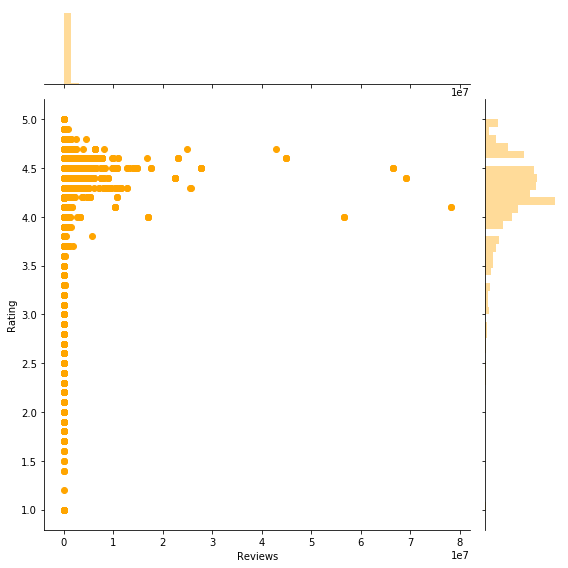

In [23]:
# Revivews and Rating
plt.figure(figsize = (10,10))
g = sns.jointplot(x="Reviews", y="Rating",color = 'orange', data=df,size = 8);

Text(0.5, 1.0, 'Rating VS Reveiws')

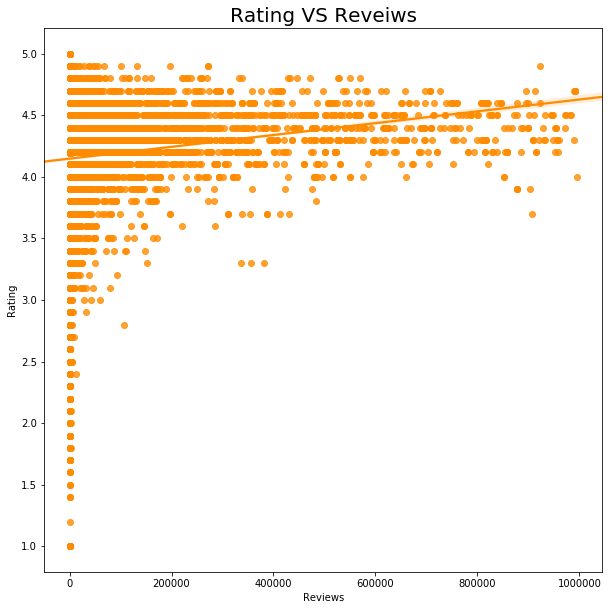

In [24]:
plt.figure(figsize = (10,10))
sns.regplot(x="Reviews", y="Rating", color = 'darkorange',data=df[df['Reviews']<1000000]);
plt.title('Rating VS Reveiws',size = 20)

Text(0.5, 1.0, 'Rating VS Installs')

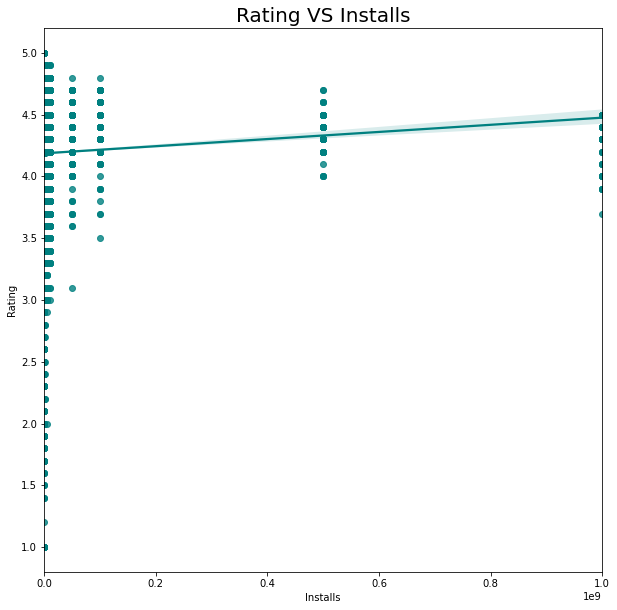

In [23]:
plt.figure(figsize = (10,10))
sns.regplot(x="Installs", y="Rating", color = 'teal',data=df)
plt.title('Rating VS Installs',size = 20)

### Model Building
#### Preprocessing: Split to X, y and Label Encoding
Drop Android Ver and Current Ver since not much business sense here.

In [32]:
df.dtypes

App                object
Category           object
Rating            float64
Reviews             int32
Size              float64
Installs            int64
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated      float64
Current Ver       float64
Android Ver        object
dtype: object

In [77]:
X = df.loc[:, ~df.columns.isin(['Rating','Android Ver','Current Ver'])]
y = df['Rating']

# Label Encoding on categorical values
le = LabelEncoder()
for i in ['Category','Type','Content Rating','Genres']:
    X[i] = le.fit_transform(X[i].values)

C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


#### Train Test Split

In [78]:
# Do Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### StandardScalar Before Regression

In [79]:
# Standard Scalar after train test split to prevent data leakage
scaler = StandardScaler()
num_cols = ['Reviews','Size','Installs','Price','Last Updated']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.fit_transform(X_test[num_cols])

C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

### Modelling:

### Linear Regression

In [80]:
from sklearn.linear_model import LinearRegression

# Creating an object of LinearRegression class
LR = LinearRegression()

# Fitting the training data

X_train = X_train.drop(labels='App', axis=1)
X_test = X_test.drop(labels='App', axis=1)

LR.fit(X_train,y_train)

#Getting Prediction
y_prediction =  LR.predict(X_test)
y_prediction

array([4.20749859, 4.23028551, 4.09882228, ..., 4.22051381, 4.21153079,
       4.17388809])

In [81]:
i=0
for column in X_train.columns: 
    print(column,LR.coef_[i])
    i+=1

Category 0.0006539031619827126
Reviews 0.028244542324720165
Size 0.009429180819958381
Installs -0.00037652941573741255
Type 0.13462706470534688
Price -0.015524807241750524
Content Rating -0.00116149515413609
Genres -0.0006430184301237624
Last Updated 0.07192441314655476


In [82]:
# Importing R Squared module
from sklearn.metrics import mean_squared_error

# Calculate OOS Mean Squared Error
LR_mse = mean_squared_error(y_test,y_prediction)
print(mean_squared_error(y_test,y_prediction))
print(np.sqrt(mean_squared_error(y_test,y_prediction)))

0.22194963162782289
0.4711153060852756


### Linear Regression with Interaction

In [83]:
from sklearn.preprocessing import PolynomialFeatures

X = X.drop(labels='App', axis=1)

#Adding Interaction Terms 
interaction = PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)
X_inter = interaction.fit_transform(X)

# Do Train Test Split for Data with Interaction Terms
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_inter, y, test_size=0.3, random_state=42)
X_train2

#Fit Models and Get Predictions
LR2 = LinearRegression()
LR2.fit(X_train2,y_train2)

y_prediction2 = LR2.predict(X_test2)
y_prediction2


array([4.21463307, 4.17934444, 4.07068211, ..., 4.2206565 , 4.19145099,
       4.17431932])

In [84]:
# Calculate OOS Mean Squared Error
LR_mse_int = mean_squared_error(y_test2,y_prediction2)
print(mean_squared_error(y_test2,y_prediction2))
print(np.sqrt(mean_squared_error(y_test2,y_prediction2)))

0.21912004424926812
0.4681026001308561


### LASSO Regression

In [86]:
#Defining Lasso
model_lasso = Lasso(alpha=0.01)

#Fitting the Model
model_lasso.fit(X_train, y_train) 
pred_train_lasso= model_lasso.predict(X_train)

# Print LASSO coefficients
coef_zip = zip(X_train.columns, model_lasso.coef_)
zipped_list = list(coef_zip)
print(zipped_list)

#Getting OOS MSE
pred_test_lasso= model_lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test,pred_test_lasso)
print(mean_squared_error(y_test,pred_test_lasso))
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 

[('Category', 0.0003492591431359316), ('Reviews', 0.018790545137149797), ('Size', 0.002479476500040324), ('Installs', 0.0), ('Type', 0.0), ('Price', -0.0), ('Content Rating', -0.0), ('Genres', -0.0005900810121726546), ('Last Updated', 0.05782715717447565)]
0.22318083058797397
0.47242018435707633


### LASSO Regression with interaction

In [91]:
#Defining Lasso
model_lasso = Lasso(alpha=0.01)

#Fitting the Model
model_lasso.fit(X_train2, y_train2) 
pred_train_lasso= model_lasso.predict(X_train2)

#Getting OOS Accuracy
pred_test_lasso2= model_lasso.predict(X_test2)
lasso_mse_int = mean_squared_error(y_test2,pred_test_lasso2)
print(mean_squared_error(y_test2,pred_test_lasso2))
print(np.sqrt(mean_squared_error(y_test2,pred_test_lasso2))) 

0.2190792051813472
0.4680589761785871


C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.346e+02, tolerance: 1.747e-01
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


### Ridge Regressions

In [90]:
#Defining Ridge
rr = Ridge(alpha=0.01)

#Fitting Model
rr.fit(X_train, y_train) 

#Getting OOS Accuracy
pred_test_rr= rr.predict(X_test)
rr_mse = mean_squared_error(y_test,pred_test_rr)
print(mean_squared_error(y_test,pred_test_rr))
print(np.sqrt(mean_squared_error(y_test,pred_test_rr))) 

0.22194962473379135
0.4711152987685619


### Ridge Regression with interaction

In [92]:
#Defining Ridge
rr = Ridge(alpha=0.01)

#Fitting Model
rr.fit(X_train2, y_train2) 

#Getting OOS Accuracy
pred_test_rr2= rr.predict(X_test2)
rr_mse_int = mean_squared_error(y_test2,pred_test_rr2)
print(rr_mse_int)
print(np.sqrt(mean_squared_error(y_test2,pred_test_rr2))) 

0.22299155036675225
0.47221981149328357


C:\Users\april\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=2.94688e-39): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


### Random Forest Regressor Model

In [93]:
# Try a baseline RF Regressor
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train,y_train)

RandomForestRegressor(n_jobs=-1)

In [96]:
predictions = model.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))

rf_mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))

print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 0.34099337138150315
Mean Squared Error: 0.28233756363935225
Root Mean Squared Error: 0.5313544613902779


### Tune RFR parameters

#### Grid Search

In [65]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rfr_gs = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

In [66]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(n_jobs=-1), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 200, 300, 1000]},
             verbose=2)

In [67]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 90,
 'max_features': 3,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 1000}

In [97]:
# fit with hyperparameters
rfr_gs = RandomForestRegressor(bootstrap=True,
 max_depth= 90,
 max_features= 3,
 min_samples_leaf= 3,
 min_samples_split= 8,
 n_estimators=1000)

rfr_gs.fit(X_train, y_train)

RandomForestRegressor(max_depth=90, max_features=3, min_samples_leaf=3,
                      min_samples_split=8, n_estimators=1000)

In [100]:
# predict
predictions = rfr_gs.predict(X_test)
rf_gs_mse = metrics.mean_squared_error(y_test, predictions)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 0.33394486512893373
Mean Squared Error: 0.27385702483807844
Root Mean Squared Error: 0.5233135053083176


### Summary Plot of MSE of all models

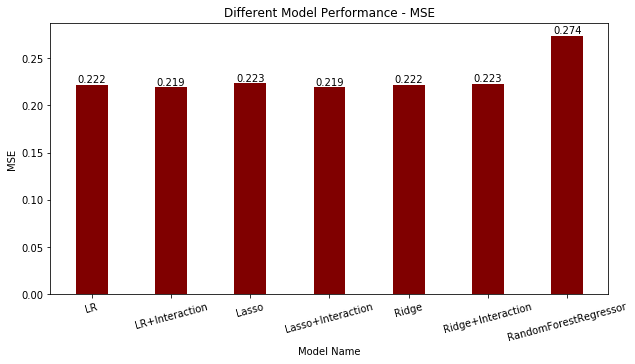

In [113]:
fig = plt.figure(figsize = (10, 5))

model_name = ['LR','LR+Interaction','Lasso','Lasso+Interaction','Ridge','Ridge+Interaction','RandomForestRegressor']
mse_list = [LR_mse,LR_mse_int,lasso_mse,lasso_mse_int,rr_mse,rr_mse_int,rf_gs_mse]

# creating the bar plot
plt.bar(model_name, mse_list, color ='maroon',
        width = 0.4)
 
plt.xlabel("Model Name")
plt.ylabel("MSE")
plt.title("Different Model Performance - MSE")
plt.xticks(rotation = 15)

for i in range(len(model_name)):
    plt.annotate(str(round(mse_list[i],3)), xy=(model_name[i],mse_list[i]), ha='center', va='bottom')

plt.show()

### Feature Importance

In [70]:
rf = RandomForestRegressor(n_estimators=60)
rf.fit(X_train, y_train)
rf.feature_importances_

array([0.08138433, 0.28520898, 0.16176821, 0.08760861, 0.00482595,
       0.0181766 , 0.02185994, 0.08895375, 0.25021363])

Text(0.5, 0, 'Random Forest Feature Importance')

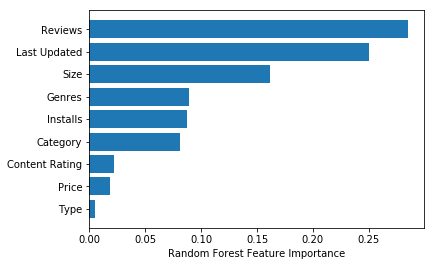

In [71]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

### Business Recommendations: Important attributes for a high-rating APPs 


#### LASSO result

In [114]:
for i in zipped_list:
    print(i)
print(np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
print(r2_score(y_test, pred_test_lasso))

('Category', 0.0003492591431359316)
('Reviews', 0.018790545137149797)
('Size', 0.002479476500040324)
('Installs', 0.0)
('Type', 0.0)
('Price', -0.0)
('Content Rating', -0.0)
('Genres', -0.0005900810121726546)
('Last Updated', 0.05782715717447565)
0.47242018435707633
0.01790283450452068


#### Random Forest Regressor Result

Text(0.5, 0, 'Random Forest Feature Importance')

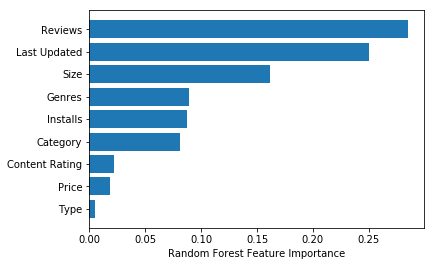

In [73]:
sorted_idx = rf.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rf.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")


#### Comining the lasso and random forest's results, we can infer the most important attributes for a high-rating APPs are: 1. Reviews 2. Last Updated 3. Size 